<h1><center>mlops Project</center></h1>

# Le Projet

L'idée ici est de simuler les matchs de la la CAN 2024 à l'aide de l'apprentissage automatique, dans le but de prédire le vainqueur de la compétition. Le projet utilise deux ensembles de données : [Résultats du football international de 1872 à 2023](https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017) et [Classement mondial FIFA 1992-2023](https://www.kaggle.com/datasets/cashncarry/fifaworldranking).

J'ai modélise le problème comme une classification binaire. J'ai utilisé cette approche pour faciliter l'analyse des résultats du modèle, de sorte que le modèle prédit soit une victoire de l'équipe à domicile, soit un match nul/une victoire de l'équipe à l'extérieur. Ensuite, pour éliminer l'avantage de l'équipe à l'extérieur, j'ai prédit les résultats en inversant les équipes à domicile et à l'extérieur (car il n'y a pas d'avantage à domicile en Coupe du Monde), et j'ai utilisé comme probabilités la moyenne des deux prédictions.


In [71]:
import pandas as pd

pd.options.display.max_columns = None
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from xgboost import XGBClassifier
import mlflow
import datetime
import warnings
warnings.filterwarnings("ignore")

In [72]:
df =  pd.read_csv('C:/Users/hp/Desktop/S5_enetcom/Mlops_project1/data/my_dataset_merge.csv')

In [73]:
import sys  
sys.path.insert(0, '../backend')

In [74]:
import os
os.environ['MLFLOW_TRACKING_USERNAME']= "Youssouf"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "2685You@"

In [75]:
#setup mlflow
mlflow.set_tracking_uri('https://dagshub.com/Youssouf/mlops_project.mlflow') #your mlfow tracking uri
mlflow.set_experiment("youssouf-experiment")

<Experiment: artifact_location='mlflow-artifacts:/4073ddc896b743d5a0f4553ec26d9ce6', creation_time=1696774111461, experiment_id='0', last_update_time=1696774111461, lifecycle_stage='active', name='youssouf-experiment', tags={}>

# Features Engineering
L'idée ici est de créer des fonctionnalités possibles qui ont un impact sur la prédiction des matchs de football. Par intuition, on dit que les features qui impactent pourraient être :

1.   Past game points made
2.   Past goals scored and suffered
3.   The importance of game (friendly or not)
4.   Rank of the teams
5.   Rank increasement of the teams
6.   Goals made and suffered by ranking faced

Donc, la première chose à faire est de créer la fonctionnalité qui indique quelle équipe a gagné et combien de points ils ont gagnés au jeu.


In [76]:
def result_finder(home, away):
    if home > away:
        return pd.Series([0, 3, 0])
    if home < away:
        return pd.Series([1, 0, 3])
    else:
        return pd.Series([2, 1, 1])

results = df.apply(lambda x: result_finder(x["home_score"], x["away_score"]), axis=1)

In [77]:
df[["result", "home_team_points", "away_team_points"]] = results

Les points de jeu sont 3 pour la victoire, 1 pour le match nul et 0 pour la défaite et sont différents des points de classement FIFA qui sont déjà dans la base de données. De plus, il est supposé que les points de classement FIFA et le classement FIFA de la même équipe sont corrélés négativement, et nous ne devrions utiliser qu'un seul d'entre eux pour créer de nouvelles features. Cette supposition est vérifiée ci-dessous :

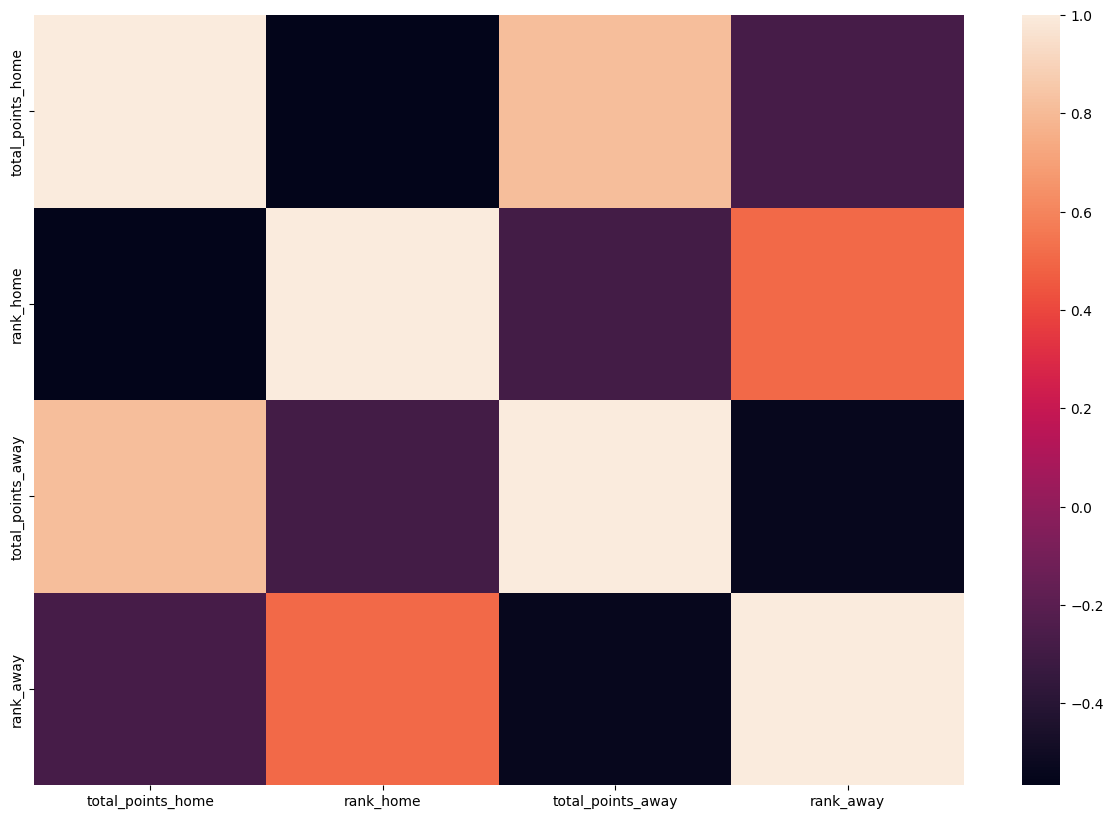

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.heatmap(df[["total_points_home", "rank_home", "total_points_away", "rank_away"]].corr())
plt.show()

In [79]:
df["rank_dif"] = df["rank_home"] - df["rank_away"]
df["sg"] = df["home_score"] - df["away_score"]
df["points_home_by_rank"] = df["home_team_points"]/df["rank_away"]
df["points_away_by_rank"] = df["away_team_points"]/df["rank_home"]

In [80]:
home_team = df[["date", "home_team", "home_score", "away_score", "rank_home", "rank_away","rank_change_home", "total_points_home", "result", "rank_dif", "points_home_by_rank", "home_team_points"]]

away_team = df[["date", "away_team", "away_score", "home_score", "rank_away", "rank_home","rank_change_away", "total_points_away", "result", "rank_dif", "points_away_by_rank", "away_team_points"]]

In [81]:
home_team.columns = [h.replace("home_", "").replace("_home", "").replace("away_", "suf_").replace("_away", "_suf") for h in home_team.columns]

away_team.columns = [a.replace("away_", "").replace("_away", "").replace("home_", "suf_").replace("_home", "_suf") for a in away_team.columns]

In [82]:
team_stats = home_team.append(away_team)#.sort_values("date")

In [83]:
team_stats

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
0,2014-08-14,Guatemala,3,0,134.0,175.0,0.0,203.00,0,-41.0,0.017143,3
1,2014-08-20,Azerbaijan,0,0,73.0,51.0,0.0,413.00,2,22.0,0.019608,1
2,2014-08-20,Panama,4,0,63.0,124.0,30.0,474.00,0,-61.0,0.024194,3
3,2014-08-23,Guatemala,1,0,134.0,124.0,0.0,203.00,0,10.0,0.024194,3
4,2014-08-26,Seychelles,1,2,180.0,178.0,-2.0,68.00,1,2.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7118,2023-07-09,Jamaica,1,0,63.0,116.0,0.0,1367.83,1,53.0,0.025862,3
7119,2023-07-09,Canada,2,2,45.0,11.0,-2.0,1454.12,2,-34.0,0.090909,1
7120,2023-07-12,Panama,1,1,57.0,11.0,-1.0,1399.23,2,-46.0,0.090909,1
7121,2023-07-12,Mexico,3,0,14.0,63.0,-1.0,1639.19,1,49.0,0.047619,3


In [84]:
#this column will be used to calculate features for simulation
team_stats_raw = team_stats.copy()

Maintenant, nous avons une base de données prête à créer des caractéristiques prédictives.
Voici les caractéristiques que nous allons calculer :




*   Moyenne des buts marqués par l'équipe lors du cycle de la Coupe du
     Monde.
*   Moyenne des buts marqués par l'équipe lors des 5 derniers matchs.
*   Moyenne des buts encaissés par l'équipe lors du cycle de la Coupe du
     Monde.
*   Moyenne des buts encaissés par l'équipe lors des 5 derniers matchs.
*   Moyenne du classement FIFA de l'adversaire auquel l'équipe a été
     confrontée lors du cycle de la Coupe du Monde.
*   Moyenne du classement FIFA de l'adversaire auquel l'équipe a été
     confrontée lors du cycle de la Coupe du Monde.
*   Points FIFA gagnés lors du cycle de la Coupe du Monde.
*   Points FIFA gagnés lors des 5 derniers matchs.
*   Moyenne des points de jeu lors du cycle de la Coupe du Monde.
*   Moyenne des points de jeu lors des 5 derniers matchs.
*   Moyenne des points de jeu lors des 5 derniers matchs.
*   Moyenne des points de jeu en fonction du classement de l'adversaire  
     lors des 5 derniers matchs.

Ces caractéristiques vous aideront à créer un modèle de prédiction des scores de matchs plus précis en prenant en compte divers aspects de la performance de l'équipe et de l'adversaire.

In [85]:
# Créez une liste vide pour stocker les statistiques calculées
stats_val = []

# Parcourez chaque ligne du DataFrame team_stats
for index, row in team_stats.iterrows():
    # Récupérez le nom de l'équipe et la date du match
    team = row["team"]
    date = row["date"]

    # Sélectionnez tous les matchs passés de l'équipe jusqu'à la date actuelle, triés par date décroissante
    past_games = team_stats.loc[(team_stats["team"] == team) & (team_stats["date"] < date)].sort_values(by=['date'], ascending=False)

    # Sélectionnez les 5 derniers matchs de l'équipe
    last5 = past_games.head(5)

    # Calculez la moyenne des buts marqués par l'équipe pour tous les matchs passés et les 5 derniers matchs
    goals = past_games["score"].mean()
    goals_l5 = last5["score"].mean()

    # Calculez la moyenne des buts encaissés par l'équipe pour tous les matchs passés et les 5 derniers matchs
    goals_suf = past_games["suf_score"].mean()
    goals_suf_l5 = last5["suf_score"].mean()

    # Calculez la moyenne du classement FIFA de l'adversaire pour tous les matchs passés et les 5 derniers matchs
    rank = past_games["rank_suf"].mean()
    rank_l5 = last5["rank_suf"].mean()

    # Calculez les points FIFA gagnés par l'équipe pour tous les matchs passés et les 5 derniers matchs
    if len(last5) > 0:
        points = past_games["total_points"].values[0] - past_games["total_points"].values[-1]  # quantité de points gagnés
        points_l5 = last5["total_points"].values[0] - last5["total_points"].values[-1]
    else:
        points = 0
        points_l5 = 0

    # Calculez la moyenne des points de jeu de l'équipe pour tous les matchs passés et les 5 derniers matchs
    gp = past_games["team_points"].mean()
    gp_l5 = last5["team_points"].mean()

    # Calculez la moyenne des points de jeu en fonction du classement de l'adversaire pour tous les matchs passés et les 5 derniers matchs
    gp_rank = past_games["points_by_rank"].mean()
    gp_rank_l5 = last5["points_by_rank"].mean()

    # Ajoutez les statistiques calculées sous forme de liste à la liste stats_val
    stats_val.append([goals, goals_l5, goals_suf, goals_suf_l5, rank, rank_l5, points, points_l5, gp, gp_l5, gp_rank, gp_rank_l5])


In [86]:
# Créez une liste des noms de colonnes pour les statistiques
stats_cols = ["goals_mean", "goals_mean_l5", "goals_suf_mean", "goals_suf_mean_l5", "rank_mean", "rank_mean_l5", "points_mean", "points_mean_l5", "game_points_mean", "game_points_mean_l5", "game_points_rank_mean", "game_points_rank_mean_l5"]

# Créez un DataFrame à partir de la liste de statistiques et des valeurs de statistiques calculées
stats_df = pd.DataFrame(stats_val, columns=stats_cols)

# Réinitialisez l'index du DataFrame team_stats et concaténez-le avec le DataFrame des statistiques
full_df = pd.concat([team_stats.reset_index(drop=True), stats_df], axis=1, ignore_index=False)

In [87]:
home_team_stats = full_df.iloc[:int(full_df.shape[0]/2),:]
away_team_stats = full_df.iloc[int(full_df.shape[0]/2):,:]

In [88]:
home_team_stats.columns[-12:]

Index(['goals_mean', 'goals_mean_l5', 'goals_suf_mean', 'goals_suf_mean_l5',
       'rank_mean', 'rank_mean_l5', 'points_mean', 'points_mean_l5',
       'game_points_mean', 'game_points_mean_l5', 'game_points_rank_mean',
       'game_points_rank_mean_l5'],
      dtype='object')

In [89]:
home_team_stats = home_team_stats[home_team_stats.columns[-12:]]
away_team_stats = away_team_stats[away_team_stats.columns[-12:]]

In [90]:
home_team_stats.columns = ['home_'+str(col) for col in home_team_stats.columns]
away_team_stats.columns = ['away_'+str(col) for col in away_team_stats.columns]

In [91]:
match_stats = pd.concat([home_team_stats, away_team_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [92]:
match_stats.head()

,home_goals_mean,home_goals_mean_l5,home_goals_suf_mean,home_goals_suf_mean_l5,home_rank_mean,home_rank_mean_l5,home_points_mean,home_points_mean_l5,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_goals_mean,away_goals_mean_l5,away_goals_suf_mean,away_goals_suf_mean_l5,away_rank_mean,away_rank_mean_l5,away_points_mean,away_points_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5
0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,3.0,3.0,0.0,0.0,175.0,175.0,0.0,0.0,3.0,3.0,0.017143,0.017143,0.0,0.0,4.0,4.0,63.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [93]:
full_df = pd.concat([df, match_stats.reset_index(drop=True)], axis=1, ignore_index=False)

In [94]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [95]:
def find_friendly(x):
    if x == "Friendly":
        return 1
    else: return 0

full_df["is_friendly"] = full_df["tournament"].apply(lambda x: find_friendly(x))

In [96]:
full_df = pd.get_dummies(full_df, columns=["is_friendly"])

In [97]:
full_df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'total_points_home',
       'previous_points_home', 'rank_home', 'rank_change_home',
       'total_points_away', 'previous_points_away', 'rank_away',
       'rank_change_away', 'result', 'home_team_points', 'away_team_points',
       'rank_dif', 'sg', 'points_home_by_rank', 'points_away_by_rank',
       'home_goals_mean', 'home_goals_mean_l5', 'home_goals_suf_mean',
       'home_goals_suf_mean_l5', 'home_rank_mean', 'home_rank_mean_l5',
       'home_points_mean', 'home_points_mean_l5', 'home_game_points_mean',
       'home_game_points_mean_l5', 'home_game_points_rank_mean',
       'home_game_points_rank_mean_l5', 'away_goals_mean',
       'away_goals_mean_l5', 'away_goals_suf_mean', 'away_goals_suf_mean_l5',
       'away_rank_mean', 'away_rank_mean_l5', 'away_points_mean',
       'away_points_mean_l5', 'away_game_points_mean',
       'away_game_points_mean_l5', 'away_

In [98]:
base_df = full_df[["date", "home_team", "away_team", "rank_home", "rank_away","home_score", "away_score","result", "rank_dif", "rank_change_home", "rank_change_away", 'home_goals_mean',
       'home_goals_mean_l5', 'home_goals_suf_mean', 'home_goals_suf_mean_l5',
       'home_rank_mean', 'home_rank_mean_l5', 'home_points_mean',
       'home_points_mean_l5', 'away_goals_mean', 'away_goals_mean_l5',
       'away_goals_suf_mean', 'away_goals_suf_mean_l5', 'away_rank_mean',
       'away_rank_mean_l5', 'away_points_mean', 'away_points_mean_l5','home_game_points_mean', 'home_game_points_mean_l5',
       'home_game_points_rank_mean', 'home_game_points_rank_mean_l5','away_game_points_mean',
       'away_game_points_mean_l5', 'away_game_points_rank_mean',
       'away_game_points_rank_mean_l5',
       'is_friendly_0', 'is_friendly_1']]

base_df.tail()

,date,home_team,away_team,rank_home,rank_away,home_score,away_score,result,rank_dif,rank_change_home,rank_change_away,home_goals_mean,home_goals_mean_l5,home_goals_suf_mean,home_goals_suf_mean_l5,home_rank_mean,home_rank_mean_l5,home_points_mean,home_points_mean_l5,away_goals_mean,away_goals_mean_l5,away_goals_suf_mean,away_goals_suf_mean_l5,away_rank_mean,away_rank_mean_l5,away_points_mean,away_points_mean_l5,home_game_points_mean,home_game_points_mean_l5,home_game_points_rank_mean,home_game_points_rank_mean_l5,away_game_points_mean,away_game_points_mean_l5,away_game_points_rank_mean,away_game_points_rank_mean_l5,is_friendly_0,is_friendly_1
7118,2023-07-09,Guatemala,Jamaica,116.0,63.0,0,1,1,53.0,0.0,0.0,1.417910,0.4,1.089552,0.4,103.328358,81.6,963.60,1.96,1.191011,1.8,1.292135,1.6,73.179775,55.4,1060.87,2.58,1.567164,1.4,0.016986,0.023465,1.235955,1.0,0.021137,0.034487,1,0
7119,2023-07-09,United States,Canada,11.0,45.0,2,2,2,-34.0,-2.0,-2.0,1.798450,2.6,0.922481,0.4,50.829457,48.2,736.34,19.57,1.949367,2.0,0.911392,1.0,79.417722,86.8,1203.12,22.48,1.806202,2.2,0.077487,0.075214,1.746835,2.0,0.031616,0.023091,1,0
7120,2023-07-12,United States,Panama,11.0,57.0,1,1,2,-46.0,-2.0,-1.0,1.800000,2.8,0.930769,0.6,50.784615,54.2,736.34,19.57,1.243478,1.6,1.426087,1.2,54.747826,47.0,925.23,0.00,1.800000,2.2,0.077062,0.066326,1.260870,1.4,0.029741,0.028361,1,0
7121,2023-07-12,Jamaica,Mexico,63.0,14.0,0,3,1,49.0,0.0,-1.0,1.188889,1.6,1.277778,1.2,73.655556,75.6,1046.83,-14.04,1.600000,2.0,0.980000,0.4,51.906667,65.0,697.19,7.32,1.255556,1.4,0.021189,0.026326,1.886667,2.4,0.077746,0.039027,1,0
7122,2023-07-16,Mexico,Panama,14.0,57.0,1,0,0,-43.0,-1.0,-1.0,1.609272,2.4,0.973510,0.4,51.980132,66.0,697.19,7.32,1.241379,1.8,1.422414,1.0,54.370690,39.8,925.23,0.00,1.894040,2.4,0.077546,0.038206,1.258621,1.6,0.030268,0.046543,1,0


In [99]:
base_df.isna().sum()

date                               0
home_team                          0
away_team                          0
rank_home                          0
rank_away                          0
home_score                         0
away_score                         0
result                             0
rank_dif                           0
rank_change_home                   0
rank_change_away                   0
home_goals_mean                   97
home_goals_mean_l5                97
home_goals_suf_mean               97
home_goals_suf_mean_l5            97
home_rank_mean                    97
home_rank_mean_l5                 97
home_points_mean                   0
home_points_mean_l5                0
away_goals_mean                  105
away_goals_mean_l5               105
away_goals_suf_mean              105
away_goals_suf_mean_l5           105
away_rank_mean                   105
away_rank_mean_l5                105
away_points_mean                   0
away_points_mean_l5                0
h

In [100]:
base_df_no_fg = base_df.dropna()

In [101]:
df = base_df_no_fg

In [102]:
def no_draw(x):
    if x == 2:
        return 1
    else:
        return x

df["target"] = df["result"].apply(lambda x: no_draw(x))

In [103]:
# Cette fonction prend en entrée un DataFrame df.
def create_db(df):
    # Liste des colonnes que nous voulons inclure dans la base de données résultante.
    columns = ["home_team", "away_team", "target", "rank_dif", "home_goals_mean", "home_rank_mean", "away_goals_mean", "away_rank_mean", "home_rank_mean_l5", "away_rank_mean_l5", "home_goals_suf_mean", "away_goals_suf_mean", "home_goals_mean_l5", "away_goals_mean_l5", "home_goals_suf_mean_l5", "away_goals_suf_mean_l5", "home_game_points_rank_mean", "home_game_points_rank_mean_l5", "away_game_points_rank_mean", "away_game_points_rank_mean_l5","is_friendly_0", "is_friendly_1"]

    # Crée un DataFrame de base en sélectionnant uniquement les colonnes spécifiées.
    base = df.loc[:, columns]

    # Calcule la différence de buts entre l'équipe à domicile et l'équipe à l'extérieur.
    base.loc[:, "goals_dif"] = base["home_goals_mean"] - base["away_goals_mean"]
    base.loc[:, "goals_dif_l5"] = base["home_goals_mean_l5"] - base["away_goals_mean_l5"]

    # Calcule la différence de buts encaissés entre l'équipe à domicile et l'équipe à l'extérieur.
    base.loc[:, "goals_suf_dif"] = base["home_goals_suf_mean"] - base["away_goals_suf_mean"]
    base.loc[:, "goals_suf_dif_l5"] = base["home_goals_suf_mean_l5"] - base["away_goals_suf_mean_l5"]

    # Calcule la différence de buts par rapport au classement FIFA.
    base.loc[:, "goals_per_ranking_dif"] = (base["home_goals_mean"] / base["home_rank_mean"]) - (base["away_goals_mean"] / base["away_rank_mean"])

    # Calcule la différence de classement entre l'équipe à domicile et l'équipe à l'extérieur.
    base.loc[:, "dif_rank_agst"] = base["home_rank_mean"] - base["away_rank_mean"]
    base.loc[:, "dif_rank_agst_l5"] = base["home_rank_mean_l5"] - base["away_rank_mean_l5"]

    # Calcule la différence de points FIFA entre l'équipe à domicile et l'équipe à l'extérieur.
    base.loc[:, "dif_points_rank"] = base["home_game_points_rank_mean"] - base["away_game_points_rank_mean"]
    base.loc[:, "dif_points_rank_l5"] = base["home_game_points_rank_mean_l5"] - base["away_game_points_rank_mean_l5"]

    # Sélectionne les colonnes finales à inclure dans le modèle.
    model_df = base[["home_team", "away_team", "target", "rank_dif", "goals_dif", "goals_dif_l5", "goals_suf_dif", "goals_suf_dif_l5", "goals_per_ranking_dif", "dif_rank_agst", "dif_rank_agst_l5", "dif_points_rank", "dif_points_rank_l5", "is_friendly_0", "is_friendly_1"]]

    # Renvoie le DataFrame résultant.
    return model_df

In [104]:
model_db = create_db(df)

In [105]:
model_db.to_csv('model_db.csv', index=False)

In [106]:
model_db

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
3,Guatemala,Cuba,0,10.0,3.000000,3.0,-4.000000,-4.0,0.017143,112.000000,112.0,0.017143,0.017143,0,1
6,Seychelles,Sri Lanka,0,2.0,-1.000000,-1.0,1.000000,1.0,-0.005493,-2.000000,-2.0,-0.016667,-0.016667,0,1
55,Costa Rica,Panama,1,-48.0,-1.000000,-1.0,0.000000,0.0,-0.015115,51.000000,51.0,-0.007051,-0.007051,1,0
56,Denmark,Armenia,0,-10.0,1.000000,1.0,0.000000,0.0,0.031250,-68.000000,-68.0,0.000000,0.000000,1,0
71,South Korea,Uruguay,1,51.0,1.000000,1.0,1.000000,1.0,0.057994,-15.000000,-15.0,0.035266,0.035266,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7118,Guatemala,Jamaica,1,53.0,0.226899,-1.4,-0.202583,-1.2,-0.002553,30.148583,26.2,-0.004150,-0.011022,1,0
7119,United States,Canada,1,-34.0,-0.150917,0.6,0.011088,-0.6,0.010836,-28.588264,-38.6,0.045871,0.052124,1,0
7120,United States,Panama,1,-46.0,0.556522,1.2,-0.495318,-0.6,0.012731,-3.963211,7.2,0.047321,0.037965,1,0
7121,Jamaica,Mexico,1,49.0,-0.411111,-0.4,0.297778,0.8,-0.014683,21.748889,10.6,-0.056556,-0.012701,1,0


# The model

Maintenant que nous avons une base de données prête et avec des colonnes à pouvoir prédictif, nous pouvons commencer notre modélisation.

Deux modèles seront testés : Random Forest et Gradient Boosting. Le sélectionné sera celui avec le meilleur rappel.

In [107]:
X = model_db.iloc[:, 3:]
y = model_db[["target"]]

In [108]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [110]:
X_train.columns

Index(['rank_dif', 'goals_dif', 'goals_dif_l5', 'goals_suf_dif',
       'goals_suf_dif_l5', 'goals_per_ranking_dif', 'dif_rank_agst',
       'dif_rank_agst_l5', 'dif_points_rank', 'dif_points_rank_l5',
       'is_friendly_0', 'is_friendly_1'],
      dtype='object')

In [111]:
import numpy as np

In [112]:
version = "v1.0"
data_url = "C:/Users/hp/Desktop/S5_enetcom/Mlops_project1/Notebook/model_db.csv"
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='GradientBoosting'):
    run_id = mlflow.active_run().info.run_id
    mlflow.log_param(f"{run_id}_data_url", data_url)
    mlflow.log_param(f"{run_id}_data_version", version)
    mlflow.log_param(f"{run_id}_input_rows", model_db.shape[0])
    mlflow.log_param(f"{run_id}_input_cols", model_db.shape[1])
    
    # Model fitting and training
    gb = GradientBoostingClassifier(random_state=5)
    
    # Définition d'un dictionnaire de paramètres à tester avec GridSearchCV
    params = {
        "learning_rate": [0.01, 0.1, 0.5],
        "min_samples_split": [5, 10],
        "min_samples_leaf": [3, 5],
        "max_depth": [3, 5, 10],
        "max_features": ["sqrt"],
        "n_estimators": [100, 200]
    }

    # Création d'une instance de GridSearchCV avec le modèle et les paramètres définis
    gb_cv = GridSearchCV(gb, params, cv=3, n_jobs=-1, verbose=False)

    # Ajustement du modèle aux données d'entraînement en utilisant la recherche sur grille
    #gb_cv.fit(X_train.values, np.ravel(y_train))

    #gb = gb_cv.best_estimator_

    mlflow.set_tag(key="model", value="GradientBoosting")
    params = gb.get_params()
    mlflow.log_params(params)
    gb_cv.fit(X_train.values, np.ravel(y_train))
    gb = gb_cv.best_estimator_
    #gb.fit(X_resampled, y_resampled)
    train_features_name = f'{X_train.values=}'.split('=')[0]
    train_label_name = f'{np.ravel(y_train)=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name", value=train_features_name)
    mlflow.set_tag(key="train_label_name", value=train_label_name)
    predicted = gb.predict(X_test)
    precision, recall, fscore, support = score(y_test, predicted, average='macro')
    mlflow.log_metric("Precision_test", precision)
    mlflow.log_metric("Recall_test", recall)
    mlflow.log_metric("F1_score_test", fscore)
    mlflow.sklearn.log_model(gb, artifact_path="ML_models")

In [113]:
# Importation du modèle de classification par Gradient Boosting
gb = GradientBoostingClassifier(random_state=5)

# Définition d'un dictionnaire de paramètres à tester avec GridSearchCV
params = {
    "learning_rate": [0.01, 0.1, 0.5],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [3, 5],
    "max_depth": [3, 5, 10],
    "max_features": ["sqrt"],
    "n_estimators": [100, 200]
}

# Création d'une instance de GridSearchCV avec le modèle et les paramètres définis
gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = False)

# Ajustement du modèle aux données d'entraînement en utilisant la recherche sur grille
gb_cv.fit(X_train.values, np.ravel(y_train))


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=False)

In [114]:
gb = gb_cv.best_estimator_

In [115]:
gb

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=5, min_samples_split=5,
                           n_estimators=200, random_state=5)

In [116]:
#gb.fit(X_resampled,y_resampled)
predicted=gb.predict(X_test)


In [117]:
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.63      0.64       648
           1       0.69      0.72      0.71       747

    accuracy                           0.68      1395
   macro avg       0.68      0.67      0.67      1395
weighted avg       0.68      0.68      0.68      1395

Confusion matrix:
 [[406 242]
 [208 539]]
Share of Non-Fraud in Test Data: target    0.4645
dtype: float64


In [118]:

mlflow.sklearn.autolog(disable=True)

with mlflow.start_run(run_name='RandomForestClassifier'):
    run_id = mlflow.active_run().info.run_id
    mlflow.log_param(f"{run_id}_data_url", data_url)
    mlflow.log_param(f"{run_id}_data_version", version)
    mlflow.log_param(f"{run_id}_input_rows", model_db.shape[0])
    mlflow.log_param(f"{run_id}_input_cols", model_db.shape[1])
    
    
    # Définition d'un dictionnaire de paramètres à tester avec GridSearchCV
    params_rf = {
    "max_depth": [20],
    "min_samples_split": [10],
    "max_leaf_nodes": [175],
    "min_samples_leaf": [5],
    "n_estimators": [250],
    "max_features": ["sqrt"],
}

    # Création d'une instance de Random Forest Classifier
    rf = RandomForestClassifier(random_state=1)

    # Création d'une instance de GridSearchCV avec le modèle Random Forest et les paramètres définis
    rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)

    # Ajustement du modèle Random Forest aux données d'entraînement en utilisant la recherche sur grille
    #rf_cv.fit(X_train.values, np.ravel(y_train))

    #rf = rf_cv.best_estimator_
    
    mlflow.set_tag(key="model", value="RandomForestClassifier")
    params = rf.get_params()
    mlflow.log_params(params)
    rf_cv.fit(X_train.values, np.ravel(y_train))
    rf = rf_cv.best_estimator_
    #rf.fit(X_resampled, y_resampled)
    train_features_name = f'{X_train.values=}'.split('=')[0]
    train_label_name = f'{np.ravel(y_train)=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name", value=train_features_name)
    mlflow.set_tag(key="train_label_name", value=train_label_name)
    predicted = rf.predict(X_test)
    precision, recall, fscore, support = score(y_test, predicted, average='macro')
    mlflow.log_metric("Precision_test", precision)
    mlflow.log_metric("Recall_test", recall)
    mlflow.log_metric("F1_score_test", fscore)
    mlflow.sklearn.log_model(rf, artifact_path="ML_models")

In [119]:
# Définition des paramètres à tester avec la recherche sur grille pour Random Forest
params_rf = {
    "max_depth": [20],
    "min_samples_split": [10],
    "max_leaf_nodes": [175],
    "min_samples_leaf": [5],
    "n_estimators": [250],
    "max_features": ["sqrt"],
}

# Création d'une instance de Random Forest Classifier
rf = RandomForestClassifier(random_state=1)

# Création d'une instance de GridSearchCV avec le modèle Random Forest et les paramètres définis
rf_cv = GridSearchCV(rf, params_rf, cv=3, n_jobs=-1, verbose=False)

# Ajustement du modèle Random Forest aux données d'entraînement en utilisant la recherche sur grille
rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [120]:
rf = rf_cv.best_estimator_

In [121]:
#rf.fit(X_resampled,y_resampled)
predictedrf=rf.predict(X_test)

In [122]:
print('Classification report:\n', classification_report(y_test, predictedrf))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predictedrf)
print('Confusion matrix:\n', conf_mat)
print('Share of Non-Fraud in Test Data:', 1-round(y_test.sum()/len(y_test),4))

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.63      0.64       648
           1       0.69      0.72      0.70       747

    accuracy                           0.68      1395
   macro avg       0.67      0.67      0.67      1395
weighted avg       0.68      0.68      0.68      1395

Confusion matrix:
 [[408 240]
 [212 535]]
Share of Non-Fraud in Test Data: target    0.4645
dtype: float64


In [123]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score,classification_report

In [124]:
def analyze(model):
    # Calcul des courbes ROC et AUC pour les ensembles de test et d'entraînement
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:,1]) # Courbe ROC du test
    plt.figure(figsize=(15,10))
    plt.plot([0, 1], [0, 1], 'k--') # Ligne en pointillés représentant la ligne de base
    plt.plot(fpr, tpr, label="test") # Courbe ROC du test

    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:,1]) # Courbe ROC de l'entraînement
    plt.plot(fpr_train, tpr_train, label="train") # Courbe ROC de l'entraînement

    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:,1]) # Score AUC du test
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:,1]) # Score AUC de l'entraînement

    plt.legend() # Légende du graphique
    plt.title('AUC score is %.2f on test and %.2f on training'%(auc_test, auc_train)) # Titre du graphique
    plt.show() # Affichage du graphique

    # Affichage de la matrice de confusion pour l'ensemble de test
    plt.figure(figsize=(15, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values)) # Matrice de confusion
    sns.heatmap(cm, annot=True, fmt="d") # Affichage de la matrice de confusion avec annotations
    predicted=model.predict(X_test)
    print('Classification report:\n', classification_report(y_test, predicted))

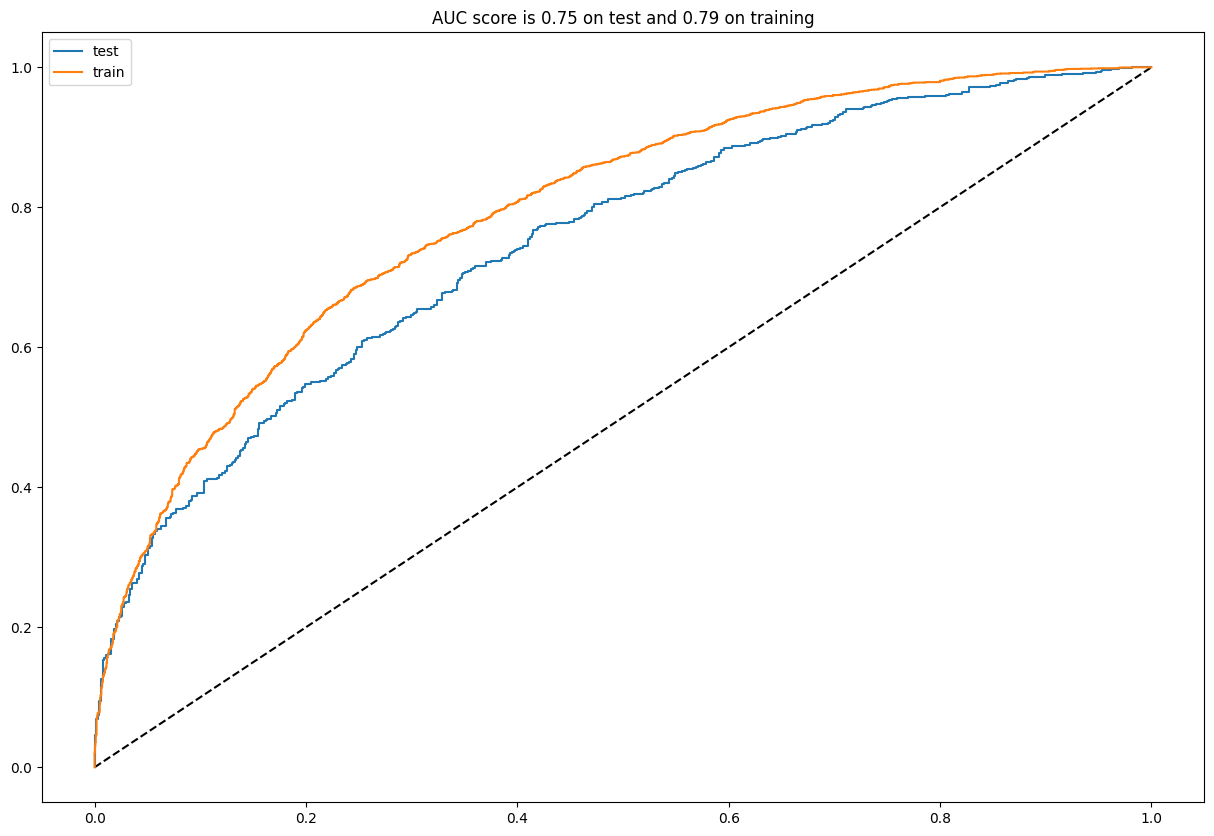

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.63      0.64       648
           1       0.69      0.72      0.71       747

    accuracy                           0.68      1395
   macro avg       0.68      0.67      0.67      1395
weighted avg       0.68      0.68      0.68      1395



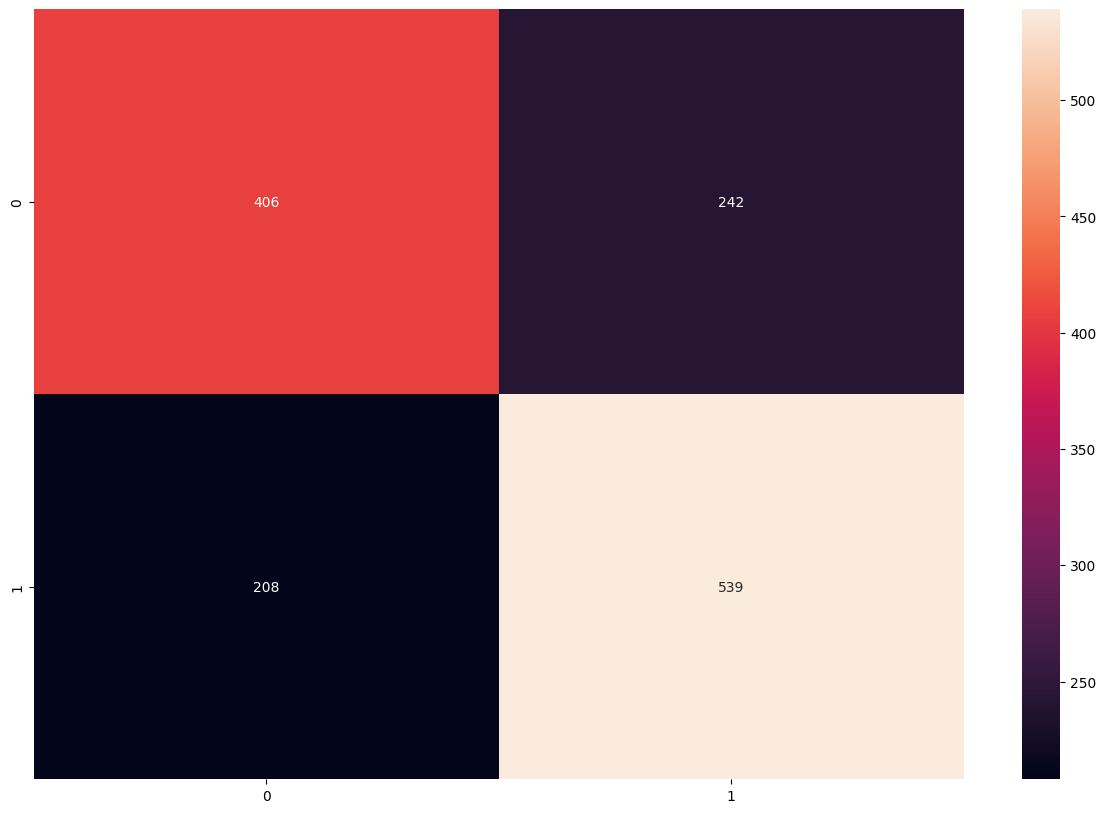

In [125]:
mlflow.sklearn.autolog(disable=True)
analyze(gb)

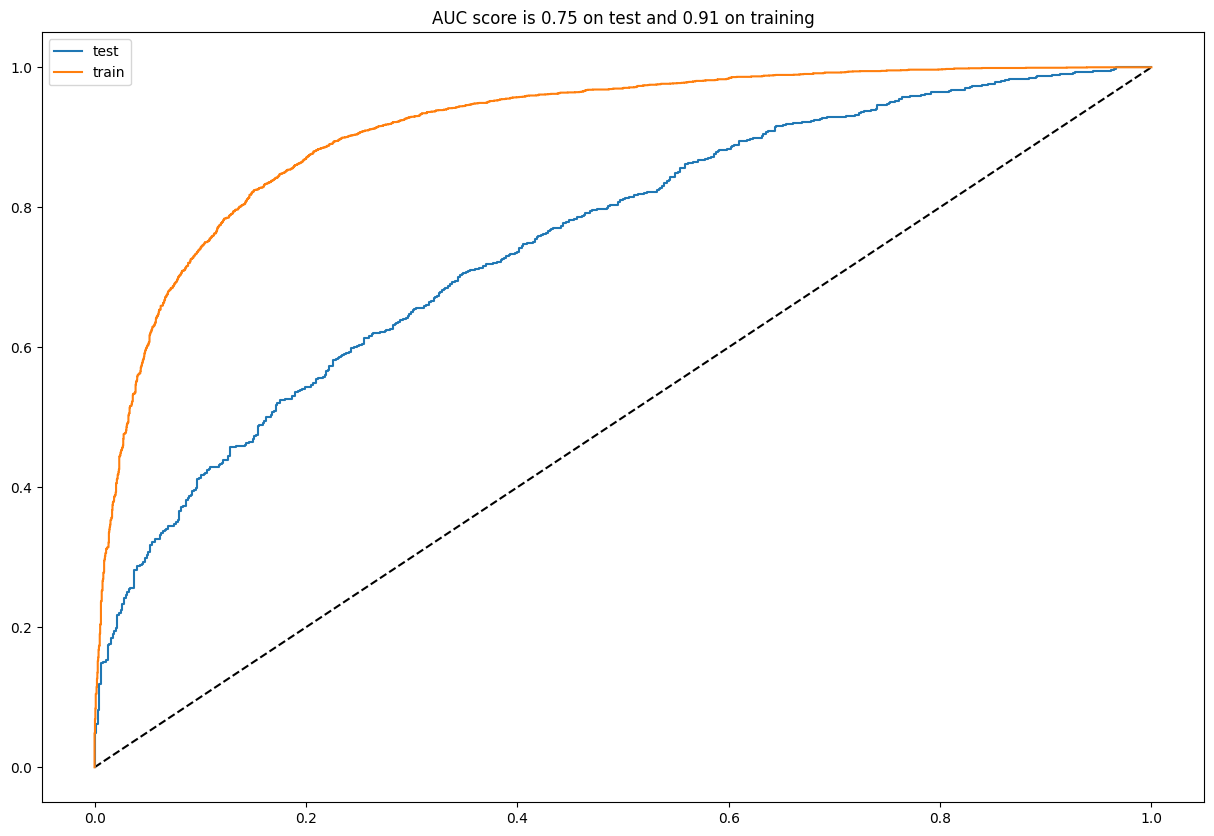

Classification report:
               precision    recall  f1-score   support

           0       0.66      0.63      0.64       648
           1       0.69      0.72      0.70       747

    accuracy                           0.68      1395
   macro avg       0.67      0.67      0.67      1395
weighted avg       0.68      0.68      0.68      1395



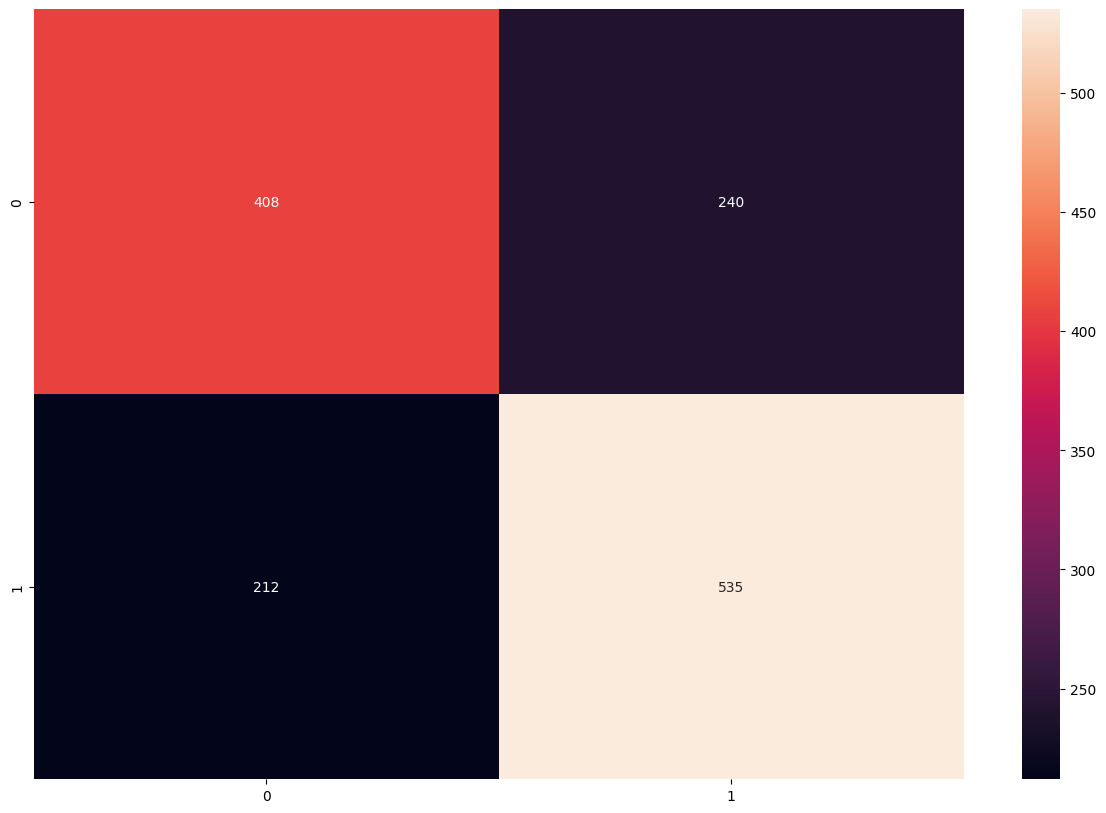

In [126]:
mlflow.sklearn.autolog(disable=True)
analyze(rf)

Le modèle Random Forest est un peu meilleur mais semble sous-ajusté. Nous allons donc utiliser le modèle Gradient Boosting.

# Gradient Boosting
Le boosting est une méthode de conversion des apprenants faibles en apprenants forts. Dans le boosting, chaque nouvel arbre correspond à une version modifiée de l'ensemble de données d'origine. L'algorithme d'amplification de gradient (gbm) peut être expliqué plus facilement en introduisant d'abord l'algorithme AdaBoost.

L'algorithme AdaBoost commence par former un arbre de décision dans lequel chaque observation se voit attribuer un poids égal. Après avoir évalué le premier arbre, nous augmentons les poids des observations difficiles à classer et diminuons les poids de celles qui sont faciles à classer. Le deuxième arbre est donc développé sur ces données pondérées. Ici, l'idée est d'améliorer les prédictions du premier arbre. Notre nouveau modèle est donc Arbre 1 + Arbre 2. Nous calculons ensuite l'erreur de classification à partir de ce nouveau modèle d'ensemble à 2 arbres et développons un troisième arbre pour prédire les résidus révisés. Nous répétons ce processus pour un nombre spécifié d'itérations. Les arbres suivants nous aident à classer les observations qui ne sont pas bien classées par les arbres précédents. Les prédictions du modèle d'ensemble final sont donc la somme pondérée des prédictions faites par les modèles d'arbres précédents.

Gradient Boosting entraîne de nombreux modèles de manière progressive, additive et séquentielle. La principale différence entre AdaBoost et Gradient Boosting Algorithm est la façon dont les deux algorithmes identifient les lacunes des apprenants faibles (par exemple, les arbres de décision). Alors que le modèle AdaBoost identifie les lacunes en utilisant des points de données à poids élevé, l'amplification de gradient effectue la même chose en utilisant des gradients dans la fonction de perte (y=ax+b+e , e nécessite une mention spéciale car il s'agit du terme d'erreur). La fonction de perte est une mesure indiquant dans quelle mesure les coefficients du modèle sont adaptés aux données sous-jacentes. Une compréhension logique de la fonction de perte dépendrait de ce que nous essayons d'optimiser.

# WC Simulation

In [127]:
#model_db['away_team'].unique()


model_db['home_team'].unique()

#model_db[(model_db.home_team == "Ivory Coast") | (model_db.away_team == "Ivory Coast")]

array(['Guatemala', 'Seychelles', 'Costa Rica', 'Denmark', 'South Korea',
       'Russia', 'Ukraine', 'Bosnia and Herzegovina', 'China PR',
       'Croatia', 'Czech Republic', 'Japan', 'Norway', 'Qatar',
       'Singapore', 'Algeria', 'Angola', 'Botswana', 'Cape Verde',
       'Congo', 'Egypt', 'Lesotho', 'Malawi', 'Mozambique',
       'South Africa', 'Togo', 'Uganda', 'Indonesia', 'Belarus',
       'Liechtenstein', 'Lithuania', 'Moldova', 'Slovakia', 'Slovenia',
       'Sweden', 'Belgium', 'Bulgaria', 'Hong Kong', 'Italy', 'Jordan',
       'Latvia', 'Malta', 'Netherlands', 'Oman', 'Saudi Arabia',
       'Senegal', 'Turkey', 'United Arab Emirates', 'Uzbekistan', 'Wales',
       'Yemen', 'Albania', 'Argentina', 'Armenia', 'Cameroon', 'Ethiopia',
       'Finland', 'France', 'Gabon', 'Guinea', 'Niger',
       'Northern Ireland', 'Romania', 'Scotland', 'Sudan', 'Austria',
       'Estonia', 'Luxembourg', 'Mexico', 'Philippines', 'Andorra',
       'Iceland', 'Kazakhstan', 'Morocco', 'Bahrain

Dans ce cas, nous avons également enregistré les points de l'équipe dans le groupe et ses probabilités de victoire dans chaque match. La moyenne des probabilités de victoire de l'équipe sera utilisée comme critère de départage lorsque deux équipes auront le même nombre de points.

In [128]:
#table
table={'A': [['Ivory Coast', 0, []],
  ['Guinea-Bissau', 0, []],
  ['Nigeria', 0, []],
  ['Equatorial Guinea', 0, []]],
 'B': [['Egypt', 0, []],          
  ['Mozambique', 0, []],
  ['Ghana', 0, []],
  ['Cape Verde', 0, []]],
 'C': [['Senegal', 0, []],
  ['Gambia', 0, []],
  ['Cameroon', 0, []],
  ['Guinea', 0, []]],
 'D': [['Mauritania', 0, []],
  ['Burkina Faso', 0, []],
  ['Algeria', 0, []],
  ['Angola', 0, []]],
  'E': [['Tunisia', 0, []],
  ['Namibia', 0, []],
  ['Mali', 0, []],
  ['South Africa', 0, []]],
  'F': [['Congo', 0, []],
  ['Zambia', 0, []],
  ['Morocco', 0, []],
  ['Tanzania', 0, []]]
}

In [129]:
team_stats_raw[(team_stats_raw.team == "Ivory Coast")].tail(5)
#team_stats_raw

,date,team,score,suf_score,rank,rank_suf,rank_change,total_points,result,rank_dif,points_by_rank,team_points
5955,2022-01-12,Ivory Coast,1,0,56.0,114.0,0.0,1417.86,1,58.0,0.026316,3
6113,2022-03-25,Ivory Coast,1,2,51.0,3.0,-5.0,1439.62,0,-48.0,0.000000,0
6187,2022-03-29,Ivory Coast,0,3,51.0,5.0,-5.0,1439.62,0,-46.0,0.000000,0
6376,2022-06-09,Ivory Coast,0,0,53.0,145.0,2.0,1435.28,2,92.0,0.006897,1
6952,2023-03-28,Ivory Coast,2,0,47.0,129.0,-1.0,1441.49,1,82.0,0.023256,3


In [130]:
matches = [('A', 'Ivory Coast', 'Guinea-Bissau'),
 ('A', 'Nigeria', 'Equatorial Guinea'),
 ('A', 'Equatorial Guinea', 'Guinea-Bissau'),
 ('A', 'Nigeria', 'Ivory Coast'),
 ('A', 'Guinea-Bissau', 'Nigeria'),
 ('A', 'Ivory Coast', 'Equatorial Guinea'),
 ('B', 'Egypt', 'Mozambique'),
 ('B', 'Ghana', 'Cape Verde'),
 ('B', 'Cape Verde', 'Mozambique'),
 ('B', 'Egypt', 'Ghana'),
 ('B', 'Mozambique', 'Ghana'),
 ('B', 'Cape Verde', 'Egypt'),
 ('C', 'Senegal', 'Gambia'),
 ('C', 'Cameroon', 'Guinea'),
 ('C', 'Senegal', 'Cameroon'),
 ('C', 'Guinea', 'Gambia'),
 ('C', 'Guinea', 'Senegal'),
 ('C', 'Gambia', 'Cameroon'),
 ('D', 'Algeria', 'Angola'),
 ('D', 'Mauritania', 'Burkina Faso'),
 ('D', 'Algeria', 'Burkina Faso'),
 ('D', 'Mauritania', 'Angola'),
 ('D', 'Angola', 'Burkina Faso'),
 ('D', 'Mauritania', 'Algeria'),
  
 ('E', 'Tunisia', 'Namibia'),
 ('E', 'Mali', 'South Africa'),
 ('E', 'Tunisia', 'Mali'),
 ('E', 'South Africa', 'Namibia'),
 ('E', 'South Africa', 'Tunisia'),
 ('E', 'Namibia', 'Mali'),

 ('F', 'Morocco', 'Tanzania'),
 ('F', 'Congo', 'Zambia'),
 ('F', 'Morocco', 'Congo'),
 ('F', 'Zambia', 'Tanzania'),
 ('F', 'Tanzania', 'Congo'),
 ('F', 'Zambia', 'Morocco')]


j'ai utiliser les statistiques du dernier match comme statistiques pour chaque équipe impliquée dans le match. Par exemple, pour le match Mauritanie contre Algerie, les statistiques du Mauritanie seront celles qu'ils avaient lors de leur dernier match, et de même pour la Algerie. Cela peut simplifier l'analyse en utilisant des données récentes pour évaluer les performances des équipes.

In [134]:
def find_stats(team_name):
        # Sélectionner tous les jeux passés de l'équipe spécifiée, triés par date.
        past_games = team_stats_raw[(team_stats_raw["team"] == team_name)].sort_values("date")
        # Sélectionner les cinq derniers jeux de l'équipe spécifiée, triés par date.
        last5 = team_stats_raw[(team_stats_raw["team"] == team_name)].sort_values("date").tail(5)
       # Extraire les statistiques pertinentes de l'équipe spécifiée.
        team_rank = past_games["rank"].values[-1]  # Classement actuel de l'équipe.
        team_goals = past_games.score.mean()        # Moyenne des buts marqués par l'équipe dans tous les jeux passés.
        team_goals_l5 = last5.score.mean()          # Moyenne des buts marqués par l'équipe dans les cinq derniers jeux.
        team_goals_suf = past_games.suf_score.mean()  # Moyenne des buts encaissés par l'équipe dans tous les jeux passés.
        team_goals_suf_l5 = last5.suf_score.mean()    # Moyenne des buts encaissés par l'équipe dans les cinq derniers jeux.
        team_rank_suf = past_games.rank_suf.mean()    # Moyenne du classement de l'opposition dans tous les jeux passés.
        team_rank_suf_l5 = last5.rank_suf.mean()      # Moyenne du classement de l'opposition dans les cinq derniers jeux.
        team_gp_rank = past_games.points_by_rank.mean()  # Moyenne des points par classement dans tous les jeux passés.
        team_gp_rank_l5 = last5.points_by_rank.mean()    # Moyenne des points par classement dans les cinq derniers jeux.

        # Retourner une liste contenant toutes les statistiques extraites.
        return [team_rank, team_goals, team_goals_l5, team_goals_suf, team_goals_suf_l5,
                team_rank_suf, team_rank_suf_l5, team_gp_rank, team_gp_rank_l5]

In [135]:
def find_features(team_1, team_2):
        # Calculer la différence entre les classements des deux équipes.
        rank_dif = team_1[0] - team_2[0]

        # Calculer la différence entre les moyennes de buts marqués par les deux équipes.
        goals_dif = team_1[1] - team_2[1]
       
        # Calculer la différence entre les moyennes de buts marqués par les deux équipes dans les cinq derniers jeux.
        goals_dif_l5 = team_1[2] - team_2[2]

        # Calculer la différence entre les moyennes de buts encaissés par les deux équipes.
        goals_suf_dif = team_1[3] - team_2[3]

        # Calculer la différence entre les moyennes de buts encaissés par les deux équipes dans les cinq derniers jeux.
        goals_suf_dif_l5 = team_1[4] - team_2[4]

        # Calculer la différence entre le ratio buts marqués/classement pour les deux équipes.
        goals_per_ranking_dif = (team_1[1] / team_1[5]) - (team_2[1] / team_2[5])
        
        # Calculer la différence entre les classements moyens de l'opposition pour les deux équipes.
        dif_rank_agst = team_1[5] - team_2[5]

        # Calculer la différence entre les classements moyens de l'opposition dans les cinq derniers jeux pour les deux équipes.
        dif_rank_agst_l5 = team_1[6] - team_2[6]

        # Calculer la différence entre les moyennes de points par classement pour les deux équipes.
        dif_gp_rank = team_1[7] - team_2[7]

        # Calculer la différence entre les moyennes de points par classement dans les cinq derniers jeux pour les deux équipes.
        dif_gp_rank_l5 = team_1[8] - team_2[8]

        return [rank_dif, goals_dif, goals_dif_l5, goals_suf_dif, goals_suf_dif_l5, goals_per_ranking_dif,
                dif_rank_agst, dif_rank_agst_l5, dif_gp_rank, dif_gp_rank_l5, 1, 0]

Maintenant que nous pouvons simuler les matchs, nous devons établir des critères pour définir un match nul, et tenir compte du fait qu'il n'y a pas d'avantage à domicile en Coupe d'afrique. L'idée est de prédire le match deux fois, en changeant l'équipe 1 et l'équipe 2. L'équipe avec la moyenne la plus élevée des probabilités sera désignée comme gagnante. En phase de groupe, si l'"équipe à domicile" gagne en tant qu'équipe 1 et perd en tant qu'équipe 2, ou si l'"équipe à domicile" gagne en tant qu'équipe 2 et perd en tant qu'équipe 1, cela sera considéré comme un match nul.

In [137]:
from operator import itemgetter
advanced_group = []
last_group = ""

for k in table.keys():
    for t in table[k]:
        t[1] = 0
        t[2] = []
        
for teams in matches:
    draw = False
    team_1 = find_stats(teams[1])
    team_2 = find_stats(teams[2])

    

    features_g1 = find_features(team_1, team_2)
    features_g2 = find_features(team_2, team_1)

    probs_g1 = gb.predict_proba([features_g1])
    probs_g2 = gb.predict_proba([features_g2])
    
    team_1_prob_g1 = probs_g1[0][0]
    team_1_prob_g2 = probs_g2[0][1]
    team_2_prob_g1 = probs_g1[0][1]
    team_2_prob_g2 = probs_g2[0][0]

    team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
    team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
    
    if ((team_1_prob_g1 > team_2_prob_g1) & (team_2_prob_g2 > team_1_prob_g2)) | ((team_1_prob_g1 < team_2_prob_g1) & (team_2_prob_g2 < team_1_prob_g2)):
        draw=True
        for i in table[teams[0]]:
            if i[0] == teams[1] or i[0] == teams[2]:
                i[1] += 1
                
    elif team_1_prob > team_2_prob:
        winner = teams[1]
        winner_proba = team_1_prob
        for i in table[teams[0]]:
            if i[0] == teams[1]:
                i[1] += 3
                
    elif team_2_prob > team_1_prob:  
        winner = teams[2]
        winner_proba = team_2_prob
        for i in table[teams[0]]:
            if i[0] == teams[2]:
                i[1] += 3
    
    for i in table[teams[0]]: #adding criterio de desempate (probs por jogo)
            if i[0] == teams[1]:
                i[2].append(team_1_prob)
            if i[0] == teams[2]:
                i[2].append(team_2_prob)

    if last_group != teams[0]:
        if last_group != "":
            print("\n")
            print("Group %s advanced: "%(last_group))
            
            for i in table[last_group]: #adding crieterio de desempate
                i[2] = np.mean(i[2])
            
            final_points = table[last_group]
            final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
            advanced_group.append([final_table[0][0], final_table[1][0],final_table[2][::]])
            for i in final_table:
                print("%s -------- %d"%(i[0], i[1]))
        print("\n")
        print("-"*10+" Starting Analysis for Group %s "%(teams[0])+"-"*10)
        
        
    if draw == False:
        print("Group %s - %s vs. %s: Winner %s with %.2f probability"%(teams[0], teams[1], teams[2], winner, winner_proba))
    else:
        print("Group %s - %s vs. %s: Draw"%(teams[0], teams[1], teams[2]))
    last_group =  teams[0]

print("\n")
print("Group %s advanced: "%(last_group))

for i in table[last_group]: #adding crieterio de desempate
    i[2] = np.mean(i[2])
            
final_points = table[last_group]
final_table = sorted(final_points, key=itemgetter(1, 2), reverse = True)
advanced_group.append([final_table[0][0], final_table[1][0],final_table[2][::]])
for i in final_table:
    print("%s -------- %d"%(i[0], i[1]))



---------- Starting Analysis for Group A ----------
Group A - Ivory Coast vs. Guinea-Bissau: Winner Ivory Coast with 0.78 probability
Group A - Nigeria vs. Equatorial Guinea: Winner Nigeria with 0.73 probability
Group A - Equatorial Guinea vs. Guinea-Bissau: Winner Equatorial Guinea with 0.57 probability
Group A - Nigeria vs. Ivory Coast: Draw
Group A - Guinea-Bissau vs. Nigeria: Winner Nigeria with 0.74 probability


Group A - Ivory Coast vs. Equatorial Guinea: Winner Ivory Coast with 0.74 probability


Group A advanced: 
Ivory Coast -------- 7
Nigeria -------- 7
Equatorial Guinea -------- 3
Guinea-Bissau -------- 0


---------- Starting Analysis for Group B ----------
Group B - Egypt vs. Mozambique: Winner Egypt with 0.80 probability
Group B - Ghana vs. Cape Verde: Winner Ghana with 0.60 probability
Group B - Cape Verde vs. Mozambique: Winner Cape Verde with 0.69 probability
Group B - Egypt vs. Ghana: Winner Egypt with 0.58 probability
Group B - Mozambique vs. Ghana: Winner Ghana with 0.77 probability
Group B - Cape Verde vs. Egypt: Winner Egypt with 0.69 probability


Group B advanced: 
Egypt -------- 9
Ghana -------- 6
Cape Verde -------- 3
Mozambique -------- 0


---------- Starting Analysis for Group C ----------
Group C - Senegal vs. Gambia: Winner Senegal with 0.79 probability
Group C - Cameroon vs. Guinea: Winner Cameroon with 0.62 probability
Group C - Senegal vs. Cameroon: Winner Senegal 

In [138]:
#Algorithme proposer par les respnsable du CAN d'appres wiki("https://en.wikipedia.org/wiki/2023_Africa_Cup_of_Nations#Teams")
[['Runner-up Group A', 'Runner-up Group C'],
 ['Winner Group D', '3rd Group B/E/F'],
 ['Winner Group B', '3rd Group A/C/D'],
 ['Winner Group F', 'Runner-up Group E'],
 ['Runner-up Group B', 'Runner-up Group F'],
 ['Winner Group A', '3rd Group c/D/E'],
 ['Winner Group E', 'Runner-up Group D'],
 ['Winner Group C', '3rd Group A/B/F']
 ]

[['Runner-up Group A', 'Runner-up Group C'],
 ['Winner Group D', '3rd Group B/E/F'],
 ['Winner Group B', '3rd Group A/C/D'],
 ['Winner Group F', 'Runner-up Group E'],
 ['Runner-up Group B', 'Runner-up Group F'],
 ['Winner Group A', '3rd Group c/D/E'],
 ['Winner Group E', 'Runner-up Group D'],
 ['Winner Group C', '3rd Group A/B/F']]

In [139]:
Advanced_Third_place={}
selected_third_place=sorted([['ABCDEF'[i]]+advanced_group[i][2] for i in range(len(advanced_group))   ],key=itemgetter(2,3),reverse=True)[:4:]
[Advanced_Third_place.update({item[0]:item[1]}) for item in selected_third_place ]
#print(Advanced_Third_place.items())
def choose(a,b,c):
    nomT=''
    if a in Advanced_Third_place.keys():
        nomT=Advanced_Third_place[a]
        Advanced_Third_place.pop(a)   
    elif b in Advanced_Third_place.keys():
        nomT=Advanced_Third_place[b]
        Advanced_Third_place.pop(b) 
    else:
        nomT=Advanced_Third_place[c]
        Advanced_Third_place.pop(c)        
    return nomT
advanced=[[advanced_group[0][1], advanced_group[2][1]],
 [advanced_group[3][0], choose('B','E','F')],
 [advanced_group[1][0], choose('A','C','D')],
 [advanced_group[5][0], advanced_group[4][1]],
 [advanced_group[1][1], advanced_group[5][1]],
 [advanced_group[0][0], choose('C','D','E')],
 [advanced_group[4][0], advanced_group[3][1]],
 [advanced_group[2][0], choose('A','B','F')]
 ]
advanced

[['Nigeria', 'Cameroon'],
 ['Algeria', 'Cape Verde'],
 ['Egypt', 'Guinea'],
 ['Morocco', 'Mali'],
 ['Ghana', 'Zambia'],
 ['Ivory Coast', 'South Africa'],
 ['Tunisia', 'Burkina Faso'],
 ['Senegal', 'Congo']]

In [140]:
playoffs = {"Round of 16": [], "Quarter-Final": [], "Semi-Final": [], "Final": []}

In [141]:
for p in playoffs.keys():
    playoffs[p] = []

actual_round = ""
next_rounds = []

for p in playoffs.keys():
    
    if p == "Round of 16":
        playoffs[p] = advanced
        
        for i in range(0, len(playoffs[p]), 1):
            game = playoffs[p][i]
            
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)

            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
        
    else:
        playoffs[p] = [[next_rounds[c], next_rounds[c+1]] for c in range(0, len(next_rounds)-1, 1) if c%2 == 0]
        next_rounds = []
        for i in range(0, len(playoffs[p])):
            game = playoffs[p][i]
            home = game[0]
            away = game[1]
            team_1 = find_stats(home)
            team_2 = find_stats(away)
            
            features_g1 = find_features(team_1, team_2)
            features_g2 = find_features(team_2, team_1)
            
            probs_g1 = gb.predict_proba([features_g1])
            probs_g2 = gb.predict_proba([features_g2])
            
            team_1_prob = (probs_g1[0][0] + probs_g2[0][1])/2
            team_2_prob = (probs_g2[0][0] + probs_g1[0][1])/2
            
            if actual_round != p:
                print("-"*10)
                print("Starting simulation of %s"%(p))
                print("-"*10)
                print("\n")
            
            if team_1_prob < team_2_prob:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, away, team_2_prob))
                next_rounds.append(away)
            else:
                print("%s vs. %s: %s advances with prob %.2f"%(home, away, home, team_1_prob))
                next_rounds.append(home)
            game.append([team_1_prob, team_2_prob])
            playoffs[p][i] = game
            actual_round = p
            

----------
Starting simulation of Round of 16
----------


Nigeria vs. Cameroon: Cameroon advances with prob 0.51
Algeria vs. Cape Verde: Algeria advances with prob 0.70
Egypt vs. Guinea: Egypt advances with prob 0.69
Morocco vs. Mali: Morocco advances with prob 0.69
Ghana vs. Zambia: Ghana advances with prob 0.64
Ivory Coast vs. South Africa: Ivory Coast advances with prob 0.60
Tunisia vs. Burkina Faso: Tunisia advances with prob 0.67
Senegal vs. Congo: Senegal advances with prob 0.77
----------
Starting simulation of Quarter-Final
----------


Cameroon vs. Algeria: Algeria advances with prob 0.58
Egypt vs. Morocco: Morocco advances with prob 0.65
Ghana vs. Ivory Coast: Ivory Coast advances with prob 0.55
Tunisia vs. Senegal: Senegal advances with prob 0.57
----------
Starting simulation of Semi-Final
----------


Algeria vs. Morocco: Morocco advances with prob 0.58
Ivory Coast vs. Senegal: Senegal advances with prob 0.61
----------
Starting simulation of Final
----------


Morocco vs

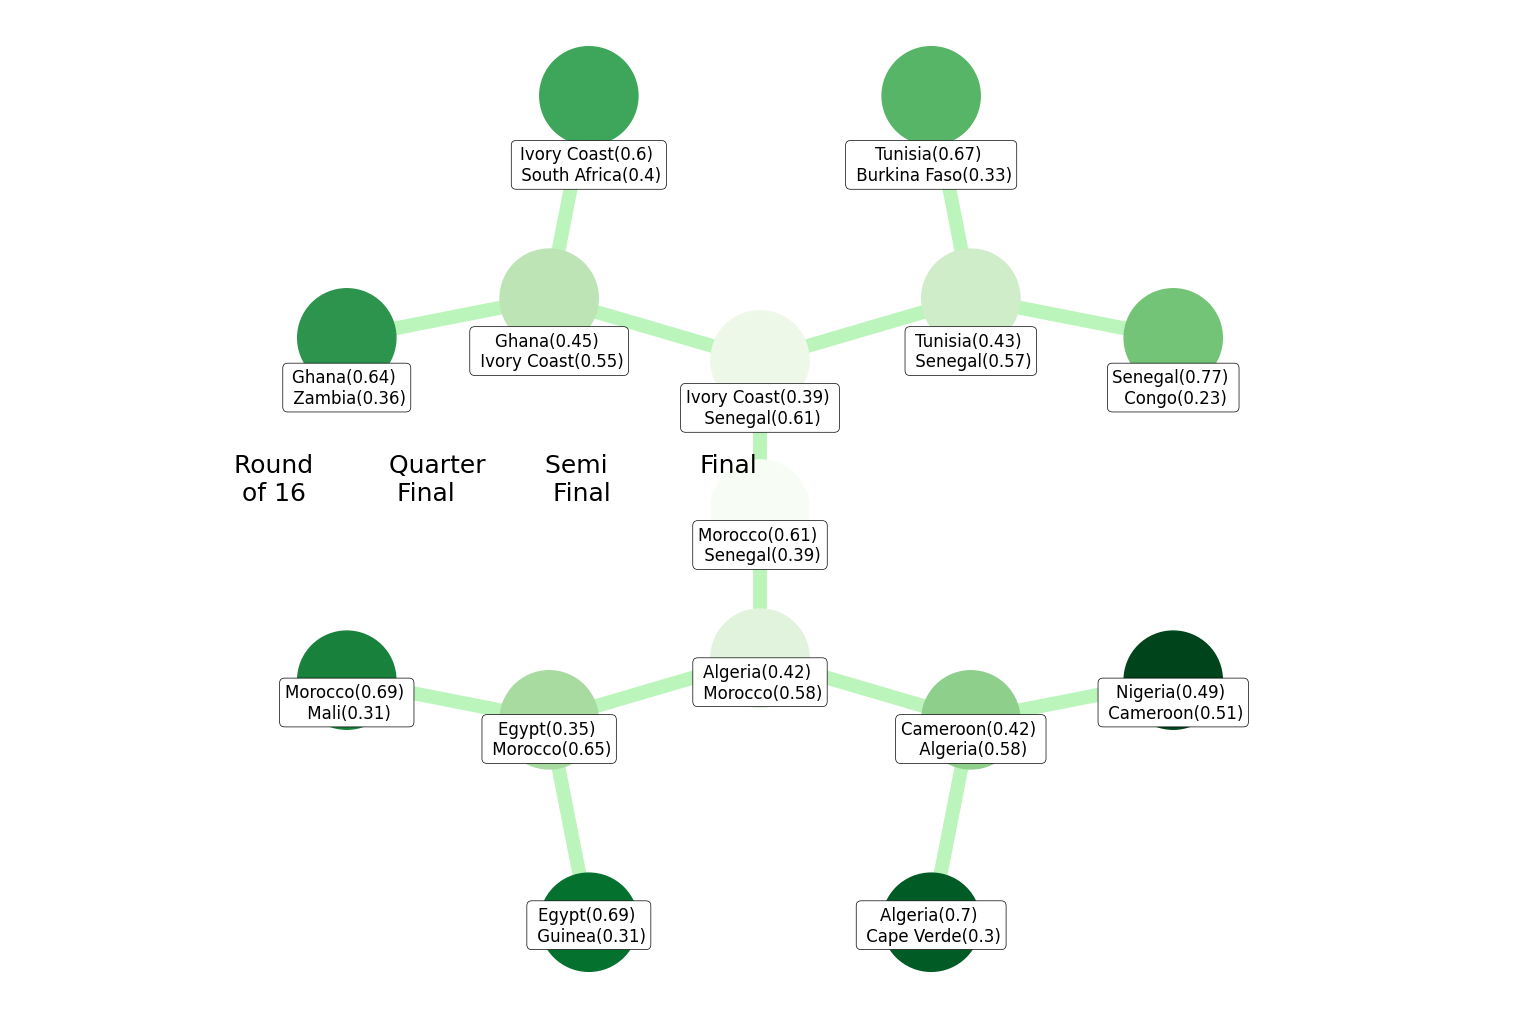

In [142]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

plt.figure(figsize=(15, 10))

G = nx.balanced_tree(2, 3)


labels = []


for p in playoffs.keys():
    for game in playoffs[p]:
        label = f"{game[0]}({round(game[2][0], 2)}) \n {game[1]}({round(game[2][1], 2)})"
        labels.append(label)
    
labels_dict = {}
labels_rev = list(reversed(labels))

for l in range(len(list(G.nodes))):
    labels_dict[l] = labels_rev[l]

pos = graphviz_layout(G, prog='twopi')

labels_pos = {n: (k[0], k[1]-0.08*k[1]) for n,k in pos.items()}
center  = pd.DataFrame(pos).mean(axis=1).mean()
    

nx.draw(G, pos = pos, with_labels=False, node_color=range(15), edge_color="#bbf5bb", width=10, font_weight='bold',cmap=plt.cm.Greens, node_size=5000)
nx.draw_networkx_labels(G, pos = labels_pos, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=labels_dict)
texts = ["Round \n of 16", "Quarter \n Final", "Semi \n Final", "Final\n"]
pos_y = pos[0][1] + 55
for text in reversed(texts):
    pos_x = center
    pos_y -= 75 
    plt.text(pos_y, pos_x, text, fontsize = 18)

plt.axis('equal')
plt.show()

In [143]:
#Reading Pandas Dataframe from mlflow
all_experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
df_mlflow = mlflow.search_runs(experiment_ids=all_experiments,filter_string="metrics.F1_score_test <1")
run_id = df_mlflow.loc[df_mlflow['metrics.F1_score_test'].idxmax()]['run_id']
print(run_id)

eb0cc5f20f5d4e21ae075b95255112ce


In [144]:
df_mlflow

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Recall_test,metrics.F1_score_test,metrics.Precision_test,params.max_leaf_nodes,params.class_weight,params.ccp_alpha,params.bootstrap,params.7d5775a100b74696be2a6a6e866d8597_data_version,params.min_samples_split,params.max_samples,params.min_impurity_decrease,params.n_estimators,params.min_samples_leaf,params.verbose,params.n_jobs,params.random_state,params.oob_score,params.warm_start,params.7d5775a100b74696be2a6a6e866d8597_input_cols,params.min_weight_fraction_leaf,params.max_features,params.max_depth,params.7d5775a100b74696be2a6a6e866d8597_data_url,params.7d5775a100b74696be2a6a6e866d8597_input_rows,params.criterion,params.a61014a49a3b4abb9d9ea1d705940227_data_version,params.tol,params.a61014a49a3b4abb9d9ea1d705940227_input_rows,params.a61014a49a3b4abb9d9ea1d705940227_input_cols,params.init,params.learning_rate,params.subsample,params.loss,params.n_iter_no_change,params.a61014a49a3b4abb9d9ea1d705940227_data_url,params.validation_fraction,params.c835cfcad5f44ac4a8a657605548641f_input_rows,params.c835cfcad5f44ac4a8a657605548641f_data_url,params.c835cfcad5f44ac4a8a657605548641f_input_cols,params.c835cfcad5f44ac4a8a657605548641f_data_version,params.4e5eaea53a32449d9683dcd3bc80f3fc_input_rows,params.4e5eaea53a32449d9683dcd3bc80f3fc_data_url,params.4e5eaea53a32449d9683dcd3bc80f3fc_input_cols,params.4e5eaea53a32449d9683dcd3bc80f3fc_data_version,params.fc5f37050c4e4f179bdb34a7213f6f1a_data_version,params.fc5f37050c4e4f179bdb34a7213f6f1a_data_url,params.fc5f37050c4e4f179bdb34a7213f6f1a_input_rows,params.fc5f37050c4e4f179bdb34a7213f6f1a_input_cols,params.53c21dd0cede46478e5a824f087f4614_data_url,params.53c21dd0cede46478e5a824f087f4614_input_rows,params.53c21dd0cede46478e5a824f087f4614_input_cols,params.53c21dd0cede46478e5a824f087f4614_data_version,params.e9ce4f61577d49248e028c71e86361e4_input_rows,params.e9ce4f61577d49248e028c71e86361e4_input_cols,params.e9ce4f61577d49248e028c71e86361e4_data_url,params.e9ce4f61577d49248e028c71e86361e4_data_version,params.b9cd8c0424e8447bb22214e1598d5118_input_rows,params.b9cd8c0424e8447bb22214e1598d5118_data_url,params.b9cd8c0424e8447bb22214e1598d5118_data_version,params.b9cd8c0424e8447bb22214e1598d5118_input_cols,params.eb0cc5f20f5d4e21ae075b95255112ce_input_cols,params.eb0cc5f20f5d4e21ae075b95255112ce_data_version,params.eb0cc5f20f5d4e21ae075b95255112ce_data_url,params.eb0cc5f20f5d4e21ae075b95255112ce_input_rows,params.75772eeb5c5849769dfa21f2963aee93_input_rows,params.75772eeb5c5849769dfa21f2963aee93_data_url,params.75772eeb5c5849769dfa21f2963aee93_input_cols,params.75772eeb5c5849769dfa21f2963aee93_data_version,params.24d42b14aab44d58afb804369b839c89_input_cols,params.24d42b14aab44d58afb804369b839c89_input_rows,params.24d42b14aab44d58afb804369b839c89_data_url,params.24d42b14aab44d58afb804369b839c89_data_version,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.user,tags.mlflow.log-model.history,tags.model,tags.train_label_name,tags.mlflow.runName,tags.train_features_name
0,7d5775a100b74696be2a6a6e866d8597,0,FINISHED,mlflow-artifacts:/4073ddc896b743d5a0f4553ec26d...,2023-10-22 18:18:21.120000+00:00,2023-10-22 18:19:44.817000+00:00,0.672914,0.673278,0.674194,None,None,0.0,True,v1.0,2,None,0.0,100,1,0,None,1,False,False,15,0.0,sqrt,None,C:/Users/hp/Desktop/S5_enetcom/Mlops_project1/...,6975,gini,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,C:\Users\hp\AppData\Roaming\Python\Python310\s...,LOCAL,youssouf,"[{""run_id"": ""7d5775a100b74696be2a6a6e866d8597""...",RandomForestClassifier,np.ravel(y_train),RandomForestClassifier,X_train.values
1,a61014a49a3b4abb9d9ea1d705940227,0,FINISHED,mlflow-artifacts:/4073ddc896b743d5a0f4553ec26d...,2023-10-22 17:58:10.820000+00:00,2023-10-22 18:09:08.003000+00:00,0.674048,0.674460,0.675689,None,None,0.0,Non

In [145]:
#let's call the model from the model registry ( in production stage)
import mlflow.pyfunc

logged_model = f'runs:/{run_id}/ML_models'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
print(loaded_model)

# Predict on a Pandas DataFrame.

loaded_model.predict(X_test)

mlflow.pyfunc.loaded_model:
  artifact_path: ML_models
  flavor: mlflow.sklearn
  run_id: eb0cc5f20f5d4e21ae075b95255112ce



array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [4]:
# ...

import mlflow
import os
os.environ['MLFLOW_TRACKING_USERNAME']= "Youssouf"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "2685You@"

#setup mlflow
mlflow.set_tracking_uri('https://dagshub.com/Youssouf/mlops_project.mlflow') #your mlfow tracking uri
#let's call the model from the model registry ( in production stage)
all_experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
df_mlflow = mlflow.search_runs(experiment_ids=all_experiments,filter_string="metrics.F1_score_test <1")
run_id = df_mlflow.loc[df_mlflow['metrics.F1_score_test'].idxmax()]['run_id']

logged_model = f'runs:/{run_id}/ML_models'
# Assurez-vous que le modèle est chargé correctement
model = mlflow.pyfunc.load_model(logged_model)

# Imprimez des informations sur le modèle
print(f"Type du modèle : {type(model)}")

# Vérifiez les méthodes disponibles pour le modèle
if hasattr(model, 'predict_proba'):
    print("Le modèle supporte la méthode predict_proba.")
else:
    print("Le modèle ne supporte pas la méthode predict_proba.")
# ...


Type du modèle : <class 'mlflow.pyfunc.PyFuncModel'>
Le modèle ne supporte pas la méthode predict_proba.
